In [1]:
from branches import *
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from time import time
import svgling.utils

Branches is an Optimal Decision Tree classifier that handles datasets with categorical features. In special cases, such as binary classification and binary features, Branches employs specialised techniques for micro-optimisation. This Tutorial illustrates how to use Branches in the general case and special cases where significant computational gains are made due to the specialised techniques.

# MONK 1

## General case: Classification with categorical features

In this first example, we consider the original Monk 1 dataset from the UCI repository.

In [2]:
data = np.genfromtxt('../data/monks-1.train', delimiter=' ', dtype=int)
data = data[:, :-1] # Getting rid of the last column, it contains only ids.
data = data[:, ::-1]

print(data.shape)

(124, 7)


We use an oridnal encoding of the dataset since it is the closest to the original dataset.

In [3]:
encoder = OrdinalEncoder()
encoder.fit(data)
data = encoder.transform(data).astype(int)

In this general case, we use Branches without specifying the encoding parameter, it is set to 'ordinal' by default.

In [4]:
lambd = 0.01
alg = Branches(data)
start_time = time()
alg.solve(lambd)
print('Execution time : %.4f' %(time() - start_time))

The search finished after 64 iterations.
Execution time : 0.0200


In [5]:
branches, splits = alg.lattice.infer()
print('Number of branches :', len(branches))
print('Number of splits :', splits)
print('Accuracy :', ((alg.predict(data[:, :-1]) == data[:, -1]).sum())/alg.n_total)

Number of branches : 27
Number of splits : 10
Accuracy : 1.0


The next cell allows the visualisation of the Optimal Decision Tree solution. Please note that while using JupyterLab for instance, you should enable a Light theme instead of a Dark one to visualise the solution in a better contrast. This can be set via Settings -> Theme -> JupyterLab Light. Note that the default renderer in Jupyter is svging, thus if the code below does not render the Decision Tree, please try running ```svgling.draw_tree(tree)``` instead.

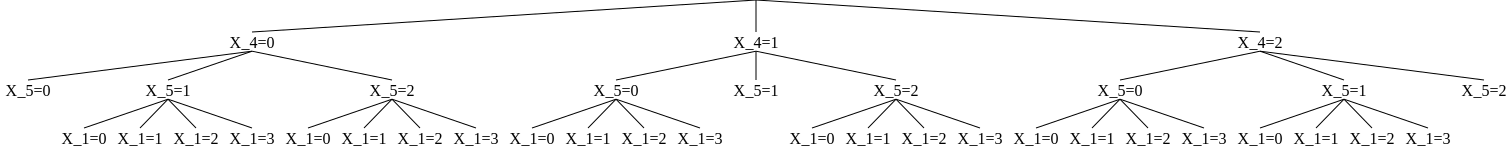

In [6]:
tree = alg.plot_tree(show_classes=False)
tree

To save this tree figure, we use the svgling package as shown below.

In [7]:
svgling.draw_tree(tree).saveas("../trees/monk1-o-no_classes.svg", pretty=True)

The figure above only includes the tree structure without the predicted classes. To show the predicted classes, set ```show_classes=True``` in the plot_tree method.

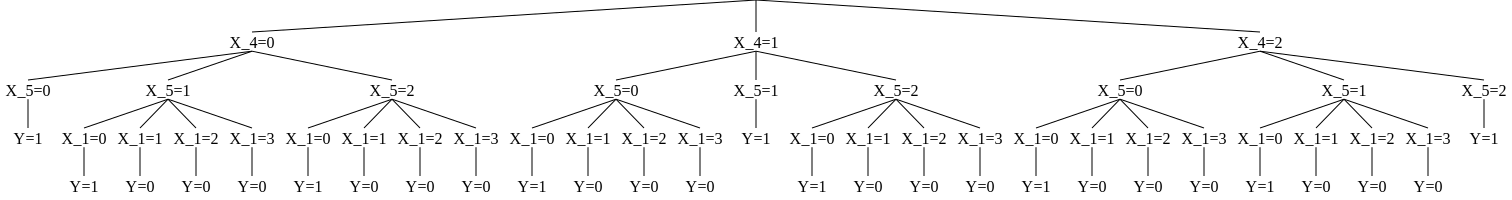

In [8]:
tree = alg.plot_tree(show_classes=True)
tree

Notice that many branches, such as (X_4=0, X_5=1) and (X_4=0, X_5=2) have the same subtree rooted at them. We can further compactify the tree representation by setting ```compact=True``` in the plot_tree method.

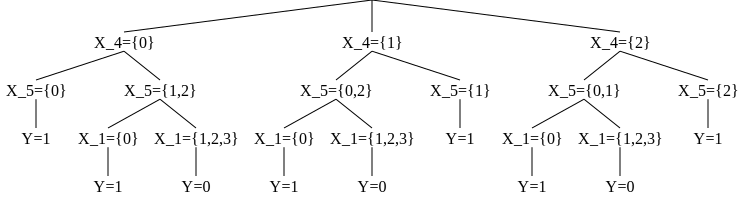

In [9]:
tree = alg.plot_tree(show_classes=True, compact=True)
tree

The following cell clears the memo.

In [10]:
alg.reinitialise()

## Special case: Binary Classification with binary featrues.

In this second example, we consider a binary encoding of Monk 1.

In [11]:
data = np.genfromtxt('../data/monks-1.train', delimiter=' ', dtype=int)
data = data[:, :-1] # Getting rid of the last column, it contains only ids.
data = data[:, ::-1]

print(data.shape)

(124, 7)


We use scikit-learn's OneHotEncoder, and we drop the last category of each feature.

In [12]:
encoder = OneHotEncoder(drop=np.array([3, 3, 2, 3, 4, 2][::-1]+[0]), sparse_output=False)
encoder.fit(data)
data = encoder.transform(data).astype(int)
print(data.shape)

(124, 12)


In [13]:
lambd = 0.01
alg = Branches(data)

start_time = time()
alg.solve(lambd)
print('Execution time : %.4f' %(time() -start_time))

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
The search finished after 617 iterations.
Execution time : 0.2657


In [14]:
alg.reinitialise()

In this first attempt, Branches converges in around $0.26s$. However, since we are dealing with a binary classification problem with binary features, we can benefit from a computational speedup due to specialised micro-optimisation techniques. We do this by specifying parameter ```encoding='binary'``` . We notice in the following cell that, indeed, the execution time of Branches drops from $0.26$ to around $0.07s$. This speedup can be even more significant in other cases.

In [15]:
alg = Branches(data, encoding='binary')
start_time = time()
alg.solve(lambd)
print('Execution time : %.4f' %(time() - start_time))

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
The search finished after 617 iterations.
Execution time : 0.0787


In [16]:
branches, splits = alg.lattice.infer()
print('Number of branches :', len(branches))
print('Number of splits :', splits)
print('Accuracy :', ((alg.predict(data[:, :-1]) == data[:, -1]).sum())/alg.n_total)

Number of branches : 8
Number of splits : 7
Accuracy : 1.0


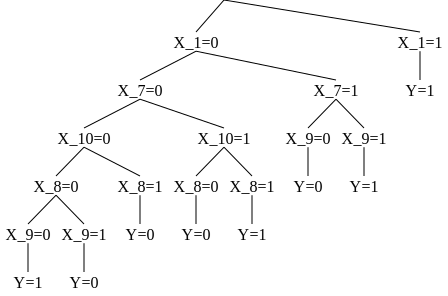

In [17]:
tree = alg.plot_tree()
tree

In [18]:
alg.reinitialise()

# Car Evaluation

## Special case: Classification with Binary features

In this last example, we consider a multiclass classification problem with binary features. For this, we use the Car Evaluation dataset from the UCI repository that we encode with scikit-learn's OneHoteEncoder.

In [19]:
data = np.genfromtxt('../data/car.data', delimiter=',', dtype=str)
X, y = data[:, :-1], data[:, -1]
print('Number of classes          :', len(set(y)))
print('Data shape before encoding :', data.shape)

encoder_X, encoder_y = OneHotEncoder(drop='first', sparse_output=False), LabelEncoder()
encoder_X.fit(X)
encoder_y.fit(y)
X = encoder_X.transform(X).astype(int)
y = encoder_y.transform(y)

data = np.hstack((X, y.reshape(-1, 1)))
print('Data shape after encoding  :', data.shape)

Number of classes          : 4
Data shape before encoding : (1728, 7)
Data shape after encoding  : (1728, 16)


In similar fashion to our previous example, we first consider the general case where we do not employ specialised techniques for handling binary features. Here Branches takes around $68s$ to converge.

In [20]:
lambd = 0.005
time_limit = 300

In [21]:
alg = Branches(data)
start_time = time()
alg.solve(lambd, n=5000000, print_iter=100000, time_limit=time_limit)
print('Execution time : %.4f' %(time() - start_time))
alg.reinitialise()

Iteration 100000
Iteration 200000
Iteration 300000
The search finished after 302811 iterations.
Execution time : 68.3941


When dealing with a multiclassification problem with binary features, set parameter ```encoding='multi'``` to benefit from micro-optimisation. We observe that the execution time drops from $68s$ to around $52s$ .

In [22]:
alg = Branches(data, encoding='multi')
start_time = time()
alg.solve(lambd, n=5000000, print_iter=100000, time_limit=time_limit)
print('Execution time : %.4f' %(time() - start_time))

Iteration 100000
Iteration 200000
Iteration 300000
The search finished after 302811 iterations.
Execution time : 52.2218


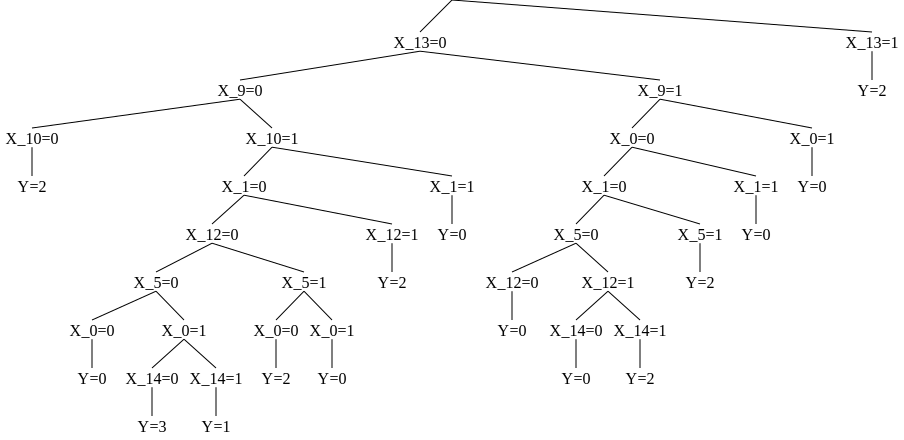

In [23]:
tree = alg.plot_tree()
tree

In [24]:
branches, splits = alg.lattice.infer()
print('Number of branches :', len(branches))
print('Number of splits :', splits)
print('Accuracy :', ((alg.predict(data[:, :-1]) == data[:, -1]).sum())/alg.n_total)

Number of branches : 15
Number of splits : 14
Accuracy : 0.8692129629629629


In [25]:
alg.reinitialise()